In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import glob, os, psutil, time

os.chdir('../core')
import ssm_scripts, ssm_fit
from utility import get_subpop_stats, gen_data
from SSID_Hankel_loss import run_bad, plot_slim, plot_outputs_l2_gradient_test
os.chdir('../dev')

#np.random.seed(0)

# define problem size
p, n, k, l, T = 100, 10, 3, 3, 500

# settings for fitting algorithm
batch_size, max_zip_size, max_iter = 1, 100, 100
a, b1, b2, e = 0.1, 0.9, 0.99, 1e-8
linearity, stable, sym_psd = 'False', False, False

# I/O matter
mmap, chunksize = True, np.min((p,2000))
data_path, save_file = '../fits/', 'test'
verbose=True

# create subpopulations
sub_pops = (np.arange(0,p), np.arange(0,p))

obs_idx, idx_grp, co_obs, _, _, _, Om, _, _ = \
    get_subpop_stats(sub_pops=sub_pops, p=p, verbose=False)

# draw system matrices 
print('(p,n,k+l,T) = ', (p,n,k+l,T), '\n')
nr = 2 # number of real eigenvalues
eig_m_r, eig_M_r, eig_m_c, eig_M_c = 0.8, 0.99, 0.8, 0.99
pars_true, x, y, Qs, idx_a, idx_b = gen_data(p,n,k,l,T, nr,
                                             eig_m_r, eig_M_r, 
                                             eig_m_c, eig_M_c,
                                             mmap, chunksize,
                                             data_path)

pars_init='default'        
np.savez(data_path + save_file, 
         pars_init=pars_init,
         pars_true=pars_true, 
         pars_est=None,
         sub_pops=sub_pops,
         p=p,n=n,T=T,k=k,l=l,
         idx_a=idx_a, idx_b=idx_b,
         x=x)          

print('\n')
print(psutil.virtual_memory())
print(psutil.swap_memory())


(p,n,k+l,T) =  (100, 10, 6, 500) 

computing empirical covariances
computing time-lagged covariance for lag  0
computing time-lagged covariance for lag  1
computing time-lagged covariance for lag  2
computing time-lagged covariance for lag  3
computing time-lagged covariance for lag  4
computing time-lagged covariance for lag  5


svmem(total=12277604352, available=10017832960, percent=18.4, used=10871504896, free=1406099456, active=2752159744, inactive=7380115456, buffers=695898112, cached=7915835392, shared=406835200)
sswap(total=0, used=0, free=0, percent=0, sin=0, sout=0)


starting descent
subsampling in time!
finished % 10.0
f =  925471100.041
finished % 20.0
f =  305842246.46
finished % 30.0
f =  250798358.503
finished % 40.0
f =  413987806.038
finished % 50.0
f =  312247133.084
finished % 60.0
f =  281295310.281
finished % 70.0
f =  281999582.861
finished % 80.0
f =  262945868.813
finished % 90.0
f =  223081276.82
finished % 100.0
f =  183478482.908
total iterations:  10000
fitting time was  10.326941013336182 s


svmem(total=12277604352, available=10041356288, percent=18.2, used=10846699520, free=1430904832, active=2730889216, inactive=7378792448, buffers=695922688, cached=7914528768, shared=405311488)
sswap(total=0, used=0, free=0, percent=0, sin=0, sout=0)


/home/mackelab/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2151: RuntimeWarning: invalid value encountered in true_divide
  return c / sqrt(multiply.outer(d, d))


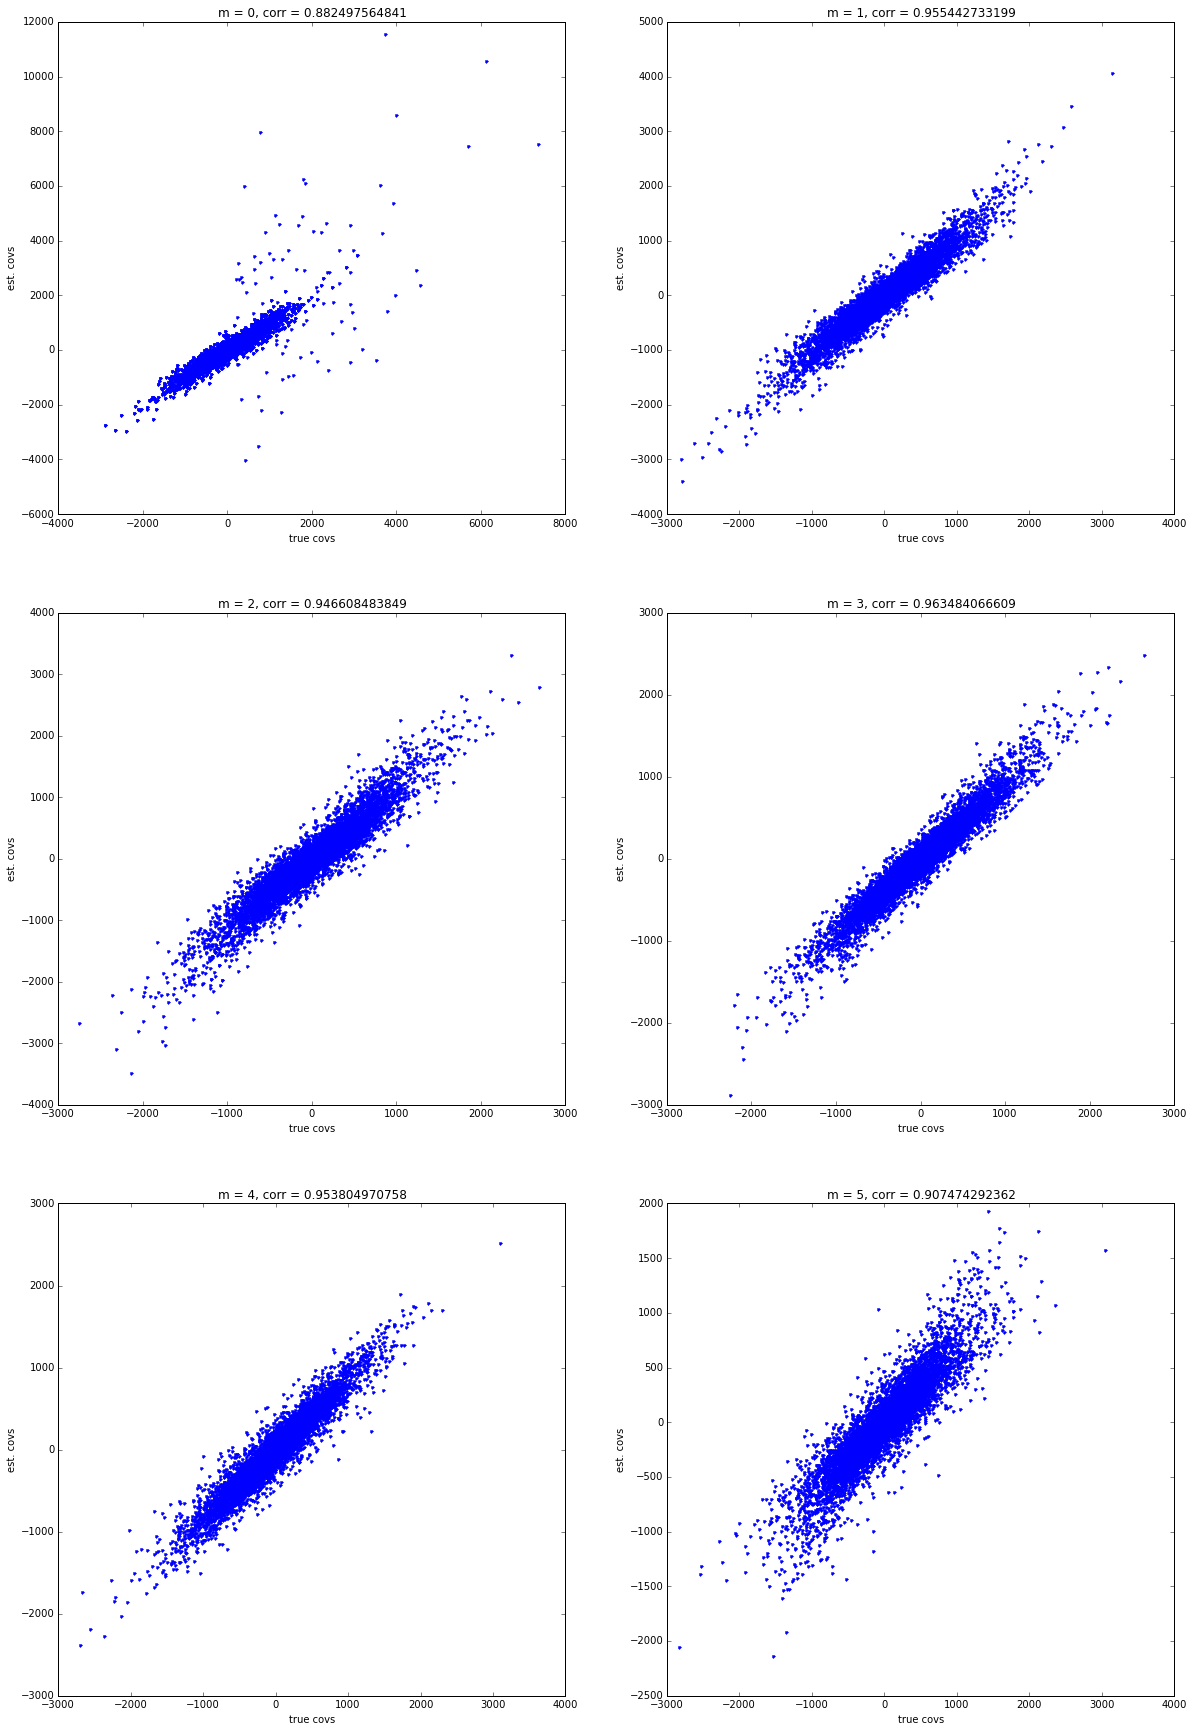

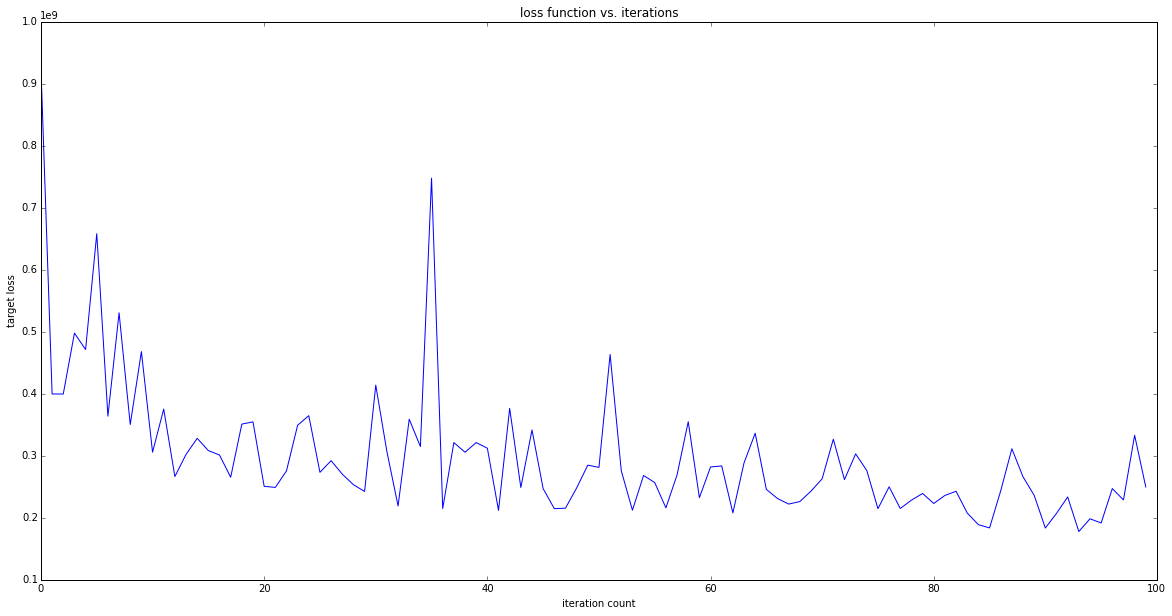

In [2]:
%matplotlib inline

t = time.time()
pars_init, pars_est, traces = run_bad(k=k,l=l,n=n,y=y, Qs=Qs,Om=Om,idx_a=idx_a, idx_b=idx_b,
                                      sub_pops=sub_pops,idx_grp=idx_grp,co_obs=co_obs,obs_idx=obs_idx,
                                      linearity=linearity,stable=stable,init=pars_init,
                                      alpha=a,b1=b1,b2=b2,e=e,max_iter=max_iter,batch_size=batch_size,
                                      verbose=verbose, sym_psd=sym_psd, max_zip_size=max_zip_size)

print('fitting time was ', time.time() - t, 's')
print('\n')
print(psutil.virtual_memory())
print(psutil.swap_memory())

plot_slim(Qs,k,l,pars_est,idx_a,idx_b,traces,mmap,data_path)

if p <= 50:
    plot_outputs_l2_gradient_test(pars_true=pars_true, pars_init=pars_init, 
                                  pars_est=pars_est, k=k, l=l, Qs=Qs, 
                                       Om=Om, traces = traces, idx_a=idx_a, idx_b=idx_b,
                                       linearity=linearity, idx_grp = idx_grp, co_obs = co_obs, 
                                       if_flip = True, m = 0)